In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pystan
import arviz

In [7]:
def read_data():
    file = '../data/chapter03/baseball_team.csv'
    df = pd.read_csv(file)
    df = df/100. # scaling
    
    return df

In [8]:
df = read_data()

In [9]:
df.head()

,G,T,C,D,DB,S
0,0.0,0.5,0.7,1.0,0.6,0.6
1,0.9,0.5,0.5,0.5,0.1,0.5
2,0.0,1.0,0.0,0.0,0.0,0.0
3,1.0,0.5,0.5,0.5,0.5,0.5
4,0.2,0.3,0.3,0.3,1.0,0.3


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 527 entries, 0 to 526
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   G       527 non-null    float64
 1   T       527 non-null    float64
 2   C       527 non-null    float64
 3   D       527 non-null    float64
 4   DB      527 non-null    float64
 5   S       527 non-null    float64
dtypes: float64(6)
memory usage: 24.8 KB


In [11]:
df.describe()

,G,T,C,D,DB,S
count,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000
mean,0.419905,0.529336,0.500019,0.429393,0.443757,0.453283
std,0.362624,0.327280,0.274880,0.261469,0.259632,0.253112
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.300000,0.400000,0.300000,0.300000,0.300000
50%,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
75%,0.800000,0.800000,0.700000,0.500000,0.600000,0.600000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


(array([ 68.,   4.,  27.,   0.,  23.,  33.,   1.,   0.,  15.,   1., 123.,
         43.,   0.,  36.,   0.,   4.,  37.,   0.,  27.,  85.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <a list of 20 Patch objects>)

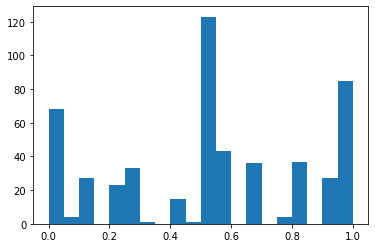

In [12]:
plt.hist(df['T'], bins=20)

In [13]:
model_code = '''
    data{
      int<lower=1> N; // sample size.
      int<lower=1> P; // number of teams.
      int<lower=1> K; // dimensions.
      real R;         // parameter of uniform distribution.
      matrix[N,P] Y;  // data matrix.
    }
    parameters{
      vector<lower=-R,upper=R>[K] theta[N];
      vector<lower=-R,upper=R>[K] delta[P];
      real<lower=0,upper=1> gamma[N];
      real<lower=-2,upper=2> alpha;
      real<lower=0> beta;
      real<lower=0> sigma[P];
    }
    model{
      matrix[N,P] mu;
      for(n in 1:N){
        for(p in 1:P){
          mu[n,p] = alpha - beta*dot_self(theta[n]-delta[p])^0.5;
        }
      }
      for(n in 1:N){
        for(p in 1:P){
          if(Y[n,p]==0.5){
            target += log_sum_exp(gamma[n], (1-gamma[n]) + normal_lpdf(0.5|mu[n,p],sigma[p]));
          }else if(Y[n,p]==0){
            target += (1-gamma[n]) + normal_lcdf(0|mu[n,p],sigma[p]);
          }else if(Y[n,p]==1){
            target += (1-gamma[n]) + normal_lccdf(1|mu[n,p],sigma[p]);
          }else{
            target += (1-gamma[n]) + normal_lpdf(Y[n,p]|mu[n,p],sigma[p]);
          }
        } 
      }
    }
'''

In [14]:
%%time
stm = pystan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b80dedd7d2b44a6d8cf7081c4e8dccd5 NOW.
C:\Users\User\anaconda3\lib\site-packages\Cython\Compiler\Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: C:\Users\User\AppData\Local\Temp\tmpg625uceb\stanfit4anon_model_b80dedd7d2b44a6d8cf7081c4e8dccd5_1036098799675388896.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


Wall time: 51.8 s


In [15]:
%%time
data = {'N':len(df) , 'P':len(df.columns), 'K':2, 'R':3.0, 'Y':df}
n_itr = 1500
n_warmup = 500
chains = 4

# Execute Sampling
fit = stm.sampling(data=data, iter=n_itr, chains=chains, n_jobs=1, warmup=n_warmup, algorithm='NUTS', verbose=True)

Wall time: 25min 2s


In [16]:
fit


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_b80dedd7d2b44a6d8cf7081c4e8dccd5.
4 chains, each with iter=1500; warmup=500; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta[1,1]   -0.18    1.31   1.97  -2.91  -2.13  -0.42   1.65   2.83      2   2.78
theta[2,1]     0.1    0.54   1.39  -2.71  -0.97   0.26   1.19   2.47      7    1.2
theta[3,1]    1.07    1.51   2.24  -2.94  -1.69   2.33   2.73   2.97      2   3.14
theta[4,1]   -0.47    0.48   1.29  -2.79  -1.46  -0.39   0.38   2.15      7   1.18
theta[5,1]   -0.84    1.17   1.89  -2.95  -2.35  -1.58   0.68   2.85      3   2.01
theta[6,1]   -0.19    0.39   1.48  -2.82   -1.3  -0.19   0.81   2.68     14   1.09
theta[7,1]    0.41    0.45    1.2  -1.95  -0.44   0.43   1.22   2.74      7   1.18
theta[8,1]    0.23    0.55   1.33  -2.45  -0.61   0.17   1.12   2.78      6   1.22
theta[9,1]    0.78    1.5